# CHEM 560 Final Project

## Contributors: Ivan Chernyshev, Ben Link, Aodong Liu, Qirui Guo

## Section I: Introduction
The structure of atoms and molecules is described by quantum mechanics, and quantum computers have the potential to simulate them better than traditional computers. Current hardware is limited due to gate error, qubit count and quantum volume. Nevertheless, Finding solutions to the structure problems traditionally requires high-performance computers with a computational cost that scales exponentially with the size of the system. But the optimization of molecular energies using medium-sized quantum computers has proven efficient for few-electron molecules. 

The question we are interested in is to find the lowest energies of molecular Hydrogen Hamiltonian as a function of hydrogen-hydrogen bond length $R$, to within chemical accuracy ($1.6\times e^{-3}$ hartree). The ground-state energy of the the Hamiltonian defines an energy surface that is used to compute chemical reaction rates, which can be used in other molecular dynamics simulations.

In CHEM560, we experimented on the variational quantum eigensolver (VQE) to solve for this problem. In this project, we will demonstrate another algorithm of quantum simulation using Trotterized simulation and the quantum phase estimation algorithm (PEA)<sup>[1]</sup>. 

### I.1 Quantum Phase Estimation

Quantum Phase Estimation Algorithm (PEA) is an algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator. The general PEA curcuit contains some ancilla qubits to represent the state $|\psi\rangle$ and $n$ qubits for the counting register. The intuition of the algorithm is to use phase kickback to write the phase of $U$ to the counting register in the Fourier basis, and then use the inverse QFT to translate it into the computational basis for measurement. The problem with PEA is that it takes $n$ qubits to measure the phase up to n-bit precision. When excuting the algorithm on an actual quantum computer, the multi-qubit gate errors from the $n$ CNOT gates brings imprecision. The error can be avoided by reducing the number of qubits we use, which leads to the Iterative Quantum Phase Estimation (IQPE) Algorithm that we will be using in this project.

The Iterative Quantum Phase Estimation algorithm implements quantum phase estimation using only one auxiliary qubit, hence the accuracy of the algorithm is restricted by the number of iterations instead of the number of counting qubits, reducing the costs for hardware requirements and gate errors.

Given a unitary operator $U$, where all the eigenvalues have a norm of 1, the algorithm estimates $U\vert\psi \rangle =e^{2\pi i \theta }|\psi \rangle$. The quantum state $|\psi\rangle$ is an eigenvector and $e^{2\pi i\theta}$ is the corresponding eigenvalue <sup>[6]</sup>. We can write the eigenvalue problem as $U |\Psi\rangle = e^{i \phi} | \Psi \rangle$, with $\phi = 2 \pi \varphi=2\pi( \varphi_1/2 + \varphi_2/4 + ... + \varphi_m/2^m) =2\pi (0.\varphi_1 \varphi_2 ... \varphi_m)$.

Assume we have a system of two qubits, $q_0$ and $q_1$, where $q_0$ is auxiliary qubit and $q_1$ represents the physical system on which the unitary $U$ operates. We initialize them as $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$, and apply control-U between $q_0$ and $q_1$ $2^t$ times to change the state of $q_0$ to $|0\rangle + e^{i 2 \pi 2^{t} \varphi} | 1 \rangle$. In other words, the phase of $U$ has been kicked back into $q_0$ as many times as the control operation has been performed.

For $t=0$, the phase encoded into $q_0$ would be $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$.

For $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi} = e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$.

...

For $t=m-1$, $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 2^{m-2} \varphi_1} e^{i 2 \pi 2^{m-3} \varphi_2} ... e^{i 2 \pi 2^{-1} \varphi_m} = e^{i 2 \pi 0.\varphi_m}$.

Here, the state of $q_0$ is $|0\rangle + e^{i 2 \pi 0.\varphi_m}|1\rangle$, which gives $|+\rangle$ if $\varphi_m = 0$ and $|-\rangle$ if $\varphi_m = 1$. When we measure $q_0$ in x-basis, the result will be $|0\rangle$ and $|1\rangle$, respectively.

In the first step, we directly measure the least significant bit $\varphi_m$ by initializing the 2-qubit registers as described above ( $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$ ), performing $2^{m-1}$ control-$U$ operations between the qubits, and measuring $q_0$ in the x-basis.

In the second step, we initialize the systems in the same way and apply $2^{m-2}$ control-$U$ operations. The relative phase in $q_0$ after these operations now becomes $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. 
To extract the phase bit $\varphi_{m-1}$, we first need to perform a phase correction by rotating around the $Z-$axis of angle $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, which results in the state of  $q_0$ to be $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. A measurement on $q_0$ in x-basis gives the phase bit $\varphi_{m-1}$.

In iteration, the $k$th step requires the application of control-$U$ $2^{m-k}$ times, a rotation around $Z$ of angle $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$, and a measurement of $q_0$ in x-basis to obtain $\varphi_{m-k+1}$,: a Hadamard transform to $q_0$, and a measurement of $q_0$ in the standard basis<sup>[7]</sup>.

### I.2 Trotterization approximation to the time-evolution operator

PEA works by preparing an initial state on the main qubit register, y-rotating the ancilla qubit's state into a superposition of $|0\rangle$ and $|1\rangle$, applying the unitary $U$ to the main qubit register controlled on the ancilla, reversing the y-rotation, and measuring. For the molecular energies we are interested in, the unitary matrix will be the time evolution operator representing the Hamiltonian. One of the most common ways to implement time evolution is through Trotterization.

As we in this class, Chemistry 560, learned when we implemented the Variational Quantum Eigensolver (VQE), it is not always straightforward to express a Hamiltonian directly on a quantum device. One way to remedy this issue is to decompose the Hamiltonian into tensor products of Pauli matrices. For the second-quantized hydrogen molecular Hamiltonian in the Hartree-Fock basis encoded using the Bravyi-Kitaev encoding, this would come in the form<sup>[1]</sup>

$\hat{H} = g_0 {\bf{I}} \otimes {\bf{I}}  + g_1 Z \otimes {\bf{I}} + g_2 {\bf{I}} \otimes Z + g_3 Z \otimes Z + g_4 X \otimes X + g_5 Y \otimes Y $

where the g's are constant coefficients set by the hydrogen bond length.

The time evolution can then be done by doing each of the components in sequence<sup>[1]</sup>:

$e^{-\it{i}\hat{H}t} = e^{-\it{i}g_0 t} e^{-\it{i}g_1 t Z \otimes {\bf{I}}} e^{-\it{i} g_2 t {\bf{I}} \otimes Z} e^{-\it{i} g_3 t Z \otimes Z} e^{-\it{i} g_4 t X \otimes X} e^{-\it{i} g_5 t Y \otimes Y}$ **(1)**

Now, according to the Baker-Campbell-Hausdorff formula, addition of non-commuting exponentials works as follows:

$e^X e^Y = e^{X + Y + \frac{1}{2}[X, Y] + \frac{1}{12}[X,[X,Y]] - \frac{1}{12}[Y,[X,Y]] + ... }$

This is our first source of error. To next-to-leading order in time, the decomposition in Equation 1 in practice equates to<sup>[2]</sup> 

$\Pi_{k=0}^n e^{-\it{i}\hat{H}_k t} = e^{-\it{i} \sum_{k=0}^n \hat{H}_k t - \frac{t^2}{2}\sum_{j=0}^{n-1}\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] + O(t^3)}$

This error becomes less pronounced as one shrinks the step-size. Hence, one can compute the time-evolution as a sequence of time-evolutions over smaller time-steps:<sup>[1]</sup>

$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t} \approx (\Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{n}})^n$

and the error in the exponential would be $\propto \frac{t^2}{2 n}\sum_{j=0}^n\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] $ <sup>[2]</sup>
    
This is called first-order Trotterization. Second-order Trotterization eliminates $O(t^2)$ error through the following formulation<sup>[3]</sup>: 
    
$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^3)} = \Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{2}} \Pi_{k = n}^0 e^{-\it{i} \hat{H}_k \frac{t}{2}} \equiv U_S^2(t)$

Similarly, for 2k-order Trotterization<sup>[3]</sup>,

$  e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^{(2k+1)})} = (U_S^{2k - 2}(p_k t))^2 U_S^{2k - 2}((1-4p_k)t)(U_S^{2k - 2}(p_k t))^2  \equiv U_S^{2k}(t)$

where $p_k = 1/(4 - 4^{\frac{1}{2k - 1}})$

### I.3 Gate errors
The other main source of error in Trotterization comes from the fidelity of the gates themselves, most notably the 2-qubit gates, which have a 97.5% fidelity when implemented on IonQ<sup>[4]</sup>. This is important to talk about, because the most typical methods for reducing the error from the Baker-Campbell-Hausdorff (BCH) formula (doing a higher-order Trotterization and decreasing the time-step size) tends to increase the number of 2-qubit gates, and hence the amount of CNOT error. Figure 1 shows the effects of both the BCH formula and the CNOT error that Martin Savage and Natalie Klco found when attempting to implement Trotterization in 2019:
    
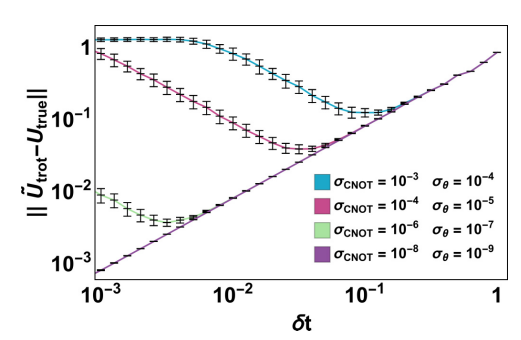

<sup>**Figure 1** Y-axis is the difference between the results of a noisy Trotterization for 1 time-unit and the results of an exact time evolution (again for 1 time-unit), calculated using the Schatten-1 norm. X-axis is the time increment of a Trotterized time evolution. $\sigma_{CNOT}$ is the error rate for a 2-qubit gate and $\sigma_\theta$ is the error-rate for a 1-qubit gate The system is a simple scalar field theory parametrized using the Jordan-Lee-Preskill method. (Borrowed from Savage and Klco 2019)</sup>

    


### I.4 Implementation in PEA
Application of the Trotterization $(\Pi_{k = 0}^n e^{-\it{i}g_k\hat{H}_k \frac{t}{n}})^n$ introduces a phase on the register:

$e^{-i H t}|\phi\rangle = (\sum_n e^{-i E_n t}|n\rangle \langle n|)|\phi\rangle=\sum_n a_n e^{-i E_n t}|n\rangle $

where $|n\rangle$ are eigenstates such that $H|n\rangle=E_n|n\rangle$ and $a_n=\langle n|\phi\rangle$.

The ancilla is intialized in the superposition state $(|0\rangle+|1\rangle)/2$. By controlling the Trotterized evolution on the ancilla, we entangle the register with the ancilla. Then measurement of the phase between the $|0\rangle$ and the $|1\rangle$ state of the ancilla gives the phase $E_nt$ and collaspes the register to the eigenstate $|n\rangle$ with probability $|a_n|^2$.

In our implementation, at iterative step $k$, the rotation $Z_{\Phi(k)}$ that serves as phase kickback contains the classical information from the previous $k-1$ measurements

$\Phi(k)=\pi\sum_{l=0}^{k-1}\frac{j_l}{2^{l-k+1}}$.

The iterative phase estimation then gives us the phase accumulated on the system. bacause our initial Hartree-Fock state ovelaps with the ground state well ($|\langle0|\phi\rangle|^2>0.5$), we can measure each bit individually with a majority-voting rule. For $b$ bits, the ground-state energy is the binary expansion of the measurement result,

$E_0^b=-\frac{\pi}{t_0}\sum_{k=0}^{b-1}\frac{j_k}{2^{k+1}}$<sup>[1]</sup>.

## Section II: Methods
We'll start by pulling together all of the necessary packages and such.

In [ ]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/33e6f75e-0499-425c-8b7d-9f593dde82b6/resourceGroups/AQET/providers/Microsoft.Quantum/Workspaces/CHEM560",
    location = "westus")
from IPython.display import Image
from IPython.core.display import HTML 
from qiskit.providers.aer import QasmSimulator
import qiskit
from qiskit.quantum_info import DensityMatrix
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.interpolate import make_interp_spline
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")
aer_simulator_backend = Aer.get_backend('aer_simulator')
qasmbackend = QasmSimulator()

For running off of a personal computer (rather than on Azure):

In [4]:
from qiskit_ionq import IonQProvider
provider = IonQProvider()# Personal IonQProvider key would go here (not included in official submission because it's confidential)
ionqsim_nat = provider.get_backend("ionq_simulator", gateset="native")
ionq_nat = provider.get_backend("ionq_qpu", gateset="native")

ionqsim_qis = provider.get_backend("ionq_simulator", gateset="native")
ionq_qis = provider.get_backend("ionq_qpu", gateset="native")
qasmbackend = QasmSimulator()

### II.1 Implementation of ideal Trotterized Hamiltonian

Below, we explore implementing a Trotterized Hamiltonian, and describe the fluctuation of the overlap with the superposition state as well as the energy for a set of radii. We start with the idealized linear algebra, then implement an ideal circuit for simulation.


In [9]:
# Exact Hamiltonian in matrix form
def Hexact(g0,g1,g2,g3,g4,g5):
    return np.array([[g0 + g1 + g2 + g3, 0, 0, g4 - g5], [0, g0 + g1 - g2 - g3, g4 + g5, 0], [0, g4 + g5, g0 - g1 + g2 - g3, 0], [g4 - g5, 0, 0, g0 - g1 - g2 + g3]])

# For the minimal energy, R0 = 0.7
H07 = Hexact(-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896)

initialstate = np.array([0,0,1,0])
ts07 = [0.01*i for i in range(2000)]

timeev07 = np.array([linalg.expm(-(1j)*t*H07) for t in ts07])

finalstates07 = np.array([np.matmul(u, initialstate) for u in timeev07])
initoverlaps07 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates07])
energies07 = np.array([np.dot(np.dot(fs,H07),fs) for fs in finalstates07])
# For R0 = 0.65
H065 = Hexact(-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883)
initialstate = np.array([0,0,1,0])
ts065 = [0.01*i for i in range(2000)]

timeev065 = np.array([linalg.expm(-(1j)*t*H065) for t in ts065])

finalstates065 = np.array([np.matmul(u, initialstate) for u in timeev065])
initoverlaps065 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates065])
energies065 = np.array([np.dot(np.dot(fs,H065),fs) for fs in finalstates065])

In [5]:
# The circuit
def trotterstep(g0,g1,g2,g3,g4,g5,dt, qc):
    #qc.crz(-g1*dt,0,1)
    #qc.crz(-g2*dt,0,2)
    
    #qc.h(1)
    #qc.h(2)
    #qc.cx(1,2)
    #qc.crz(-2*g4*dt,0,2)
    #qc.cx(1,2)
    #qc.h(1)
    #qc.h(2)
    
    qc.rz(2*g1*dt,0)
    qc.rz(2*g2*dt,1)
    
    qc.h(0)
    qc.h(1)
    qc.cx(0,1)
    qc.rz(4*g4*dt,1)
    qc.cx(0,1)
    qc.h(0)
    qc.h(1)
    
    return qc

trotterstep(1,1,1,1,1,1,0.1, QuantumCircuit(2,2)).draw()

┌─────────┐┌───┐                     ┌───┐
q_0: ┤ Rz(0.2) ├┤ H ├──■───────────────■──┤ H ├
     ├─────────┤├───┤┌─┴─┐┌─────────┐┌─┴─┐├───┤
q_1: ┤ Rz(0.2) ├┤ H ├┤ X ├┤ Rz(0.4) ├┤ X ├┤ H ├
     └─────────┘└───┘└───┘└─────────┘└───┘└───┘
c: 2/══════════════════════════════════════════

In [6]:
# trotterstep iterator
def trotterizer_overlap(g0,g1,g2,g3,g4,g5,t, nsteps, bak, shotcount):
    dt = t/nsteps
    
    qc22 = QuantumCircuit(2,2)
    
    qc22.x(0)
    
    for i in range(nsteps):
        trotterstep(g0,g1,g2,g3,g4,g5,dt, qc22)
        
    qc22.x(0)
        
    qc22.measure(0,0)
    qc22.measure(1,1)
    
    job_22 = bak.run(qc22, shots=shotcount)

    result_22 = job_22.result()
    counts_22 = result_22.get_counts(qc22)
    
    if '00' in counts_22.keys():
        return counts_22['00']/shotcount
    
    else:
        return 0
    

In [7]:
# R = 0.7
ts07_qis = [0.01*(i+1) for i in range(2000)]
niters07 = [(i+1) for i in range(2000)]

initialoverlaps07 = np.array([trotterizer_overlap(-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896, ts07_qis[i], i, qasmbackend, 1000) for i in niters07[:1000]])

# R = 0.65
ts65_qis = [0.01*(i+1) for i in range(2000)]
niters65 = [(i+1) for i in range(2000)]

initialoverlaps65 = np.array([trotterizer_overlap(-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883, ts65_qis[i], i, qasmbackend, 1000) for i in niters65[:1000]])


/Users/ivan/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


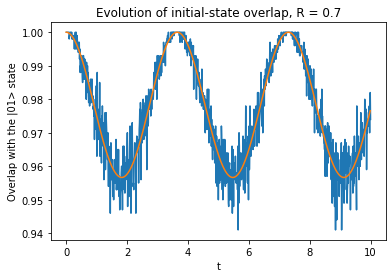

In [10]:
plt.title("Evolution of initial-state overlap, R = 0.7")
plt.ylabel("Overlap with the |01> state")
plt.xlabel("t")
plt.plot(ts07_qis[:1000], initialoverlaps07[:1000])
plt.plot(ts07[:1000], initoverlaps07[:1000])
plt.show()

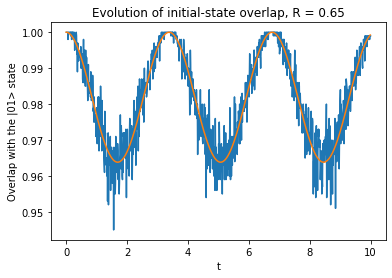

In [11]:
plt.title("Evolution of initial-state overlap, R = 0.65")
plt.ylabel("Overlap with the |01> state")
plt.xlabel("t")
plt.plot(ts65_qis[:1000], initialoverlaps65[:1000])
plt.plot(ts065[:1000], initoverlaps065[:1000])
plt.show()

The set of two plots above show the time evolution in the ideal case for two molecular radii (in orange). We see that the energy fluctuates significantly for each case, while the overlap very slightly away from exact overlap. These can examples are also implemented to show the this case in a first-order Trotterization on an ideal quantum circuit (blue) (with a time-step of 0.01). Here, the Trotter error (from the Baker-Campbell-Hausdorff formula) shows its effect, as the Trotterized version dances around the ideal orange curve.

### II.2 Iterative Phase Estimation Algorithm

Now, we can move to the implementation of the iterative phase estimation algorithm with the Trotterized Hamiltonian proposed previously. We start by defining a function that takes in the necessary parameters to construct our quantum circuit. These parameters include the number of Trotter steps we take, the specific coupling constants for the given bond length, and the parameter phi that we determine from another function. 

In [ ]:
### Functions to get our circuit, phi, and energy
def construct_circuit(k,prev_result,t0,num_cycles,g_list):
    ### Start by constructing the base circuit. This entails having a set of 
    ### three qubits and measurement of just the last qubit. 
    ### For our purposes, qubit 0 is our ancilla qubit, while qubits
    ### 1 and 2 will hold the state information for our hydrogen molecule

    # Determine phi based on k
    phi = get_phi(prev_result)
    step = t0/num_cycles

    PEA_Circuit=QuantumCircuit(3,1)
    
    PEA_Circuit.x(1)
    PEA_Circuit.h(0)
    PEA_Circuit.rz(phi,0)
    PEA_Circuit.barrier()
    ### Now we apply our unitary Trotter, which is a set of applied gates to
    # simulate the Hamiltonian. The four hamiltonians
    # are applied based off Appendix C in the paper:
    # https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007.
    for i in range(num_cycles):
        #Z0 rotation
        PEA_Circuit.rz(-2**k*step*g_list[1]/2,0)
        PEA_Circuit.crz(2**k*step*g_list[1],0,1)
        PEA_Circuit.barrier()
        #Z1 rotation
        PEA_Circuit.rz(-2**k*step*g_list[2]/2,0)
        PEA_Circuit.crz(2**k*step*g_list[2],0,2)
        PEA_Circuit.barrier()
        # X0X1
        PEA_Circuit.rz(-2**k*step*g_list[4]/2,0)
        PEA_Circuit.ry(np.pi/2,1)
        PEA_Circuit.ry(np.pi/2,2)
        PEA_Circuit.cx(2,1)
        PEA_Circuit.crz(2**k*step*g_list[4],0,1)
        PEA_Circuit.cx(2,1)
        PEA_Circuit.ry(-np.pi/2,1)
        PEA_Circuit.ry(-np.pi/2,2)
        PEA_Circuit.barrier()
        # Y0Y1
        PEA_Circuit.rz(-2**k*step*g_list[5]/2,0)
        PEA_Circuit.rx(np.pi/2,1)
        PEA_Circuit.rx(np.pi/2,2)
        PEA_Circuit.cx(2,1)
        PEA_Circuit.crz(2**k*step*g_list[5],0,1)
        PEA_Circuit.cx(2,1)
        PEA_Circuit.rx(-np.pi/2,1)
        PEA_Circuit.rx(-np.pi/2,2)
        PEA_Circuit.barrier()

    # Final rotation on ancilla
    PEA_Circuit.h(0)
    
    PEA_Circuit.measure(0,0)
    return PEA_Circuit



Now we need functions to determine the phase-kickback angle $\phi$ for our circuit. This is done from Equation 7 from the O'Malley paper.

In [25]:
### function to determine phi based on previous measurements
def get_phi(prev_results):
    sum = 0
    k = len(prev_results)
    for l in range(k):
        sum += prev_results[l]/(2**(l-k+1))
    return sum*np.pi


Finally. let's define the functions that will evaluate the bit value we get from one iteration of the IPEA, and another to determine the final energy based on all iterations of the IPEA.

In [ ]:
### Function to return the final energy based on all measurements
def get_energy(prev_results,t0,g0,g3,radius):
    b=len(prev_results)
    sum = 0
    for k in range(b):
        sum += prev_results[k]/(2**(k+1))
    return -np.pi*sum/t0+g0-g3 + 1/(radius/0.52917721092)

### Function to return the majority rules candidate
def maj_rule(job_result):
    count0 = 0
    count1 = 0
    if ('0' in job_result.get_counts()):
        count0 = job_result.get_counts()['0']
    if ('1' in job_result.get_counts()):
        count1 = job_result.get_counts()['1']
    if (count0 > count1):
        return 0
    elif (count1 > count0):
        return 1
    else:
        return 0

Finally, for completeness, we define the procedural function that will apply these functions for us. This is so that we have simple, direct control of each parameter we include in the circuit procedure.

In [28]:
def procedural(t0,g_list,backend,number_cycles,number_runs,number_shots,radius):
    ### storage values
    prev_res = []
    ### total number of cycles we would like to run
    for i in range(number_runs):
        qc = construct_circuit(i+1,prev_res,t0,number_cycles,g_list)
        qc_trans = transpile(qc,backend)
        job = backend.run(qc_trans,shots=number_shots)
        ind_result = job.result()
        prev_res.append(maj_rule(ind_result))
    
    ### Once out of loop, can compute energy
    return get_energy(prev_res,t0,g_list[0],g_list[3],radius)

## Section III: Results & Discussion ##


### III.1 Testing the Effect of K and Number of Trotter steps ###
Since $k$ controls how many phase kickbacks we want to use, and the number of Trotter steps ($n$) controls how many times we apply $U_{\text{Trott}}$, increasing the values of these two parameters should result in a higher accuracy. In this subsection, we study the effect of $k$ and $n$ on Aer simulator.

We will generate a list of $k$, then run PEA experiment at $R= 0.75$ Angstrom and $n = 100$. 

In [ ]:
k_list = np.arange(1,101,5)
E_list = []
num_step = 100
num_shot = 1000
bond_length = 0.75
g_list = [-0.4804,0.3288,-0.4347,0.5716,0.0910,0.0910]
t0 = 0.74

for i in range(len(k_list)):
    Energy = procedural(t0,g_list,aer_simulator_backend,num_step,k_list[i],num_shot,bond_length)
    E_list.append(Energy)

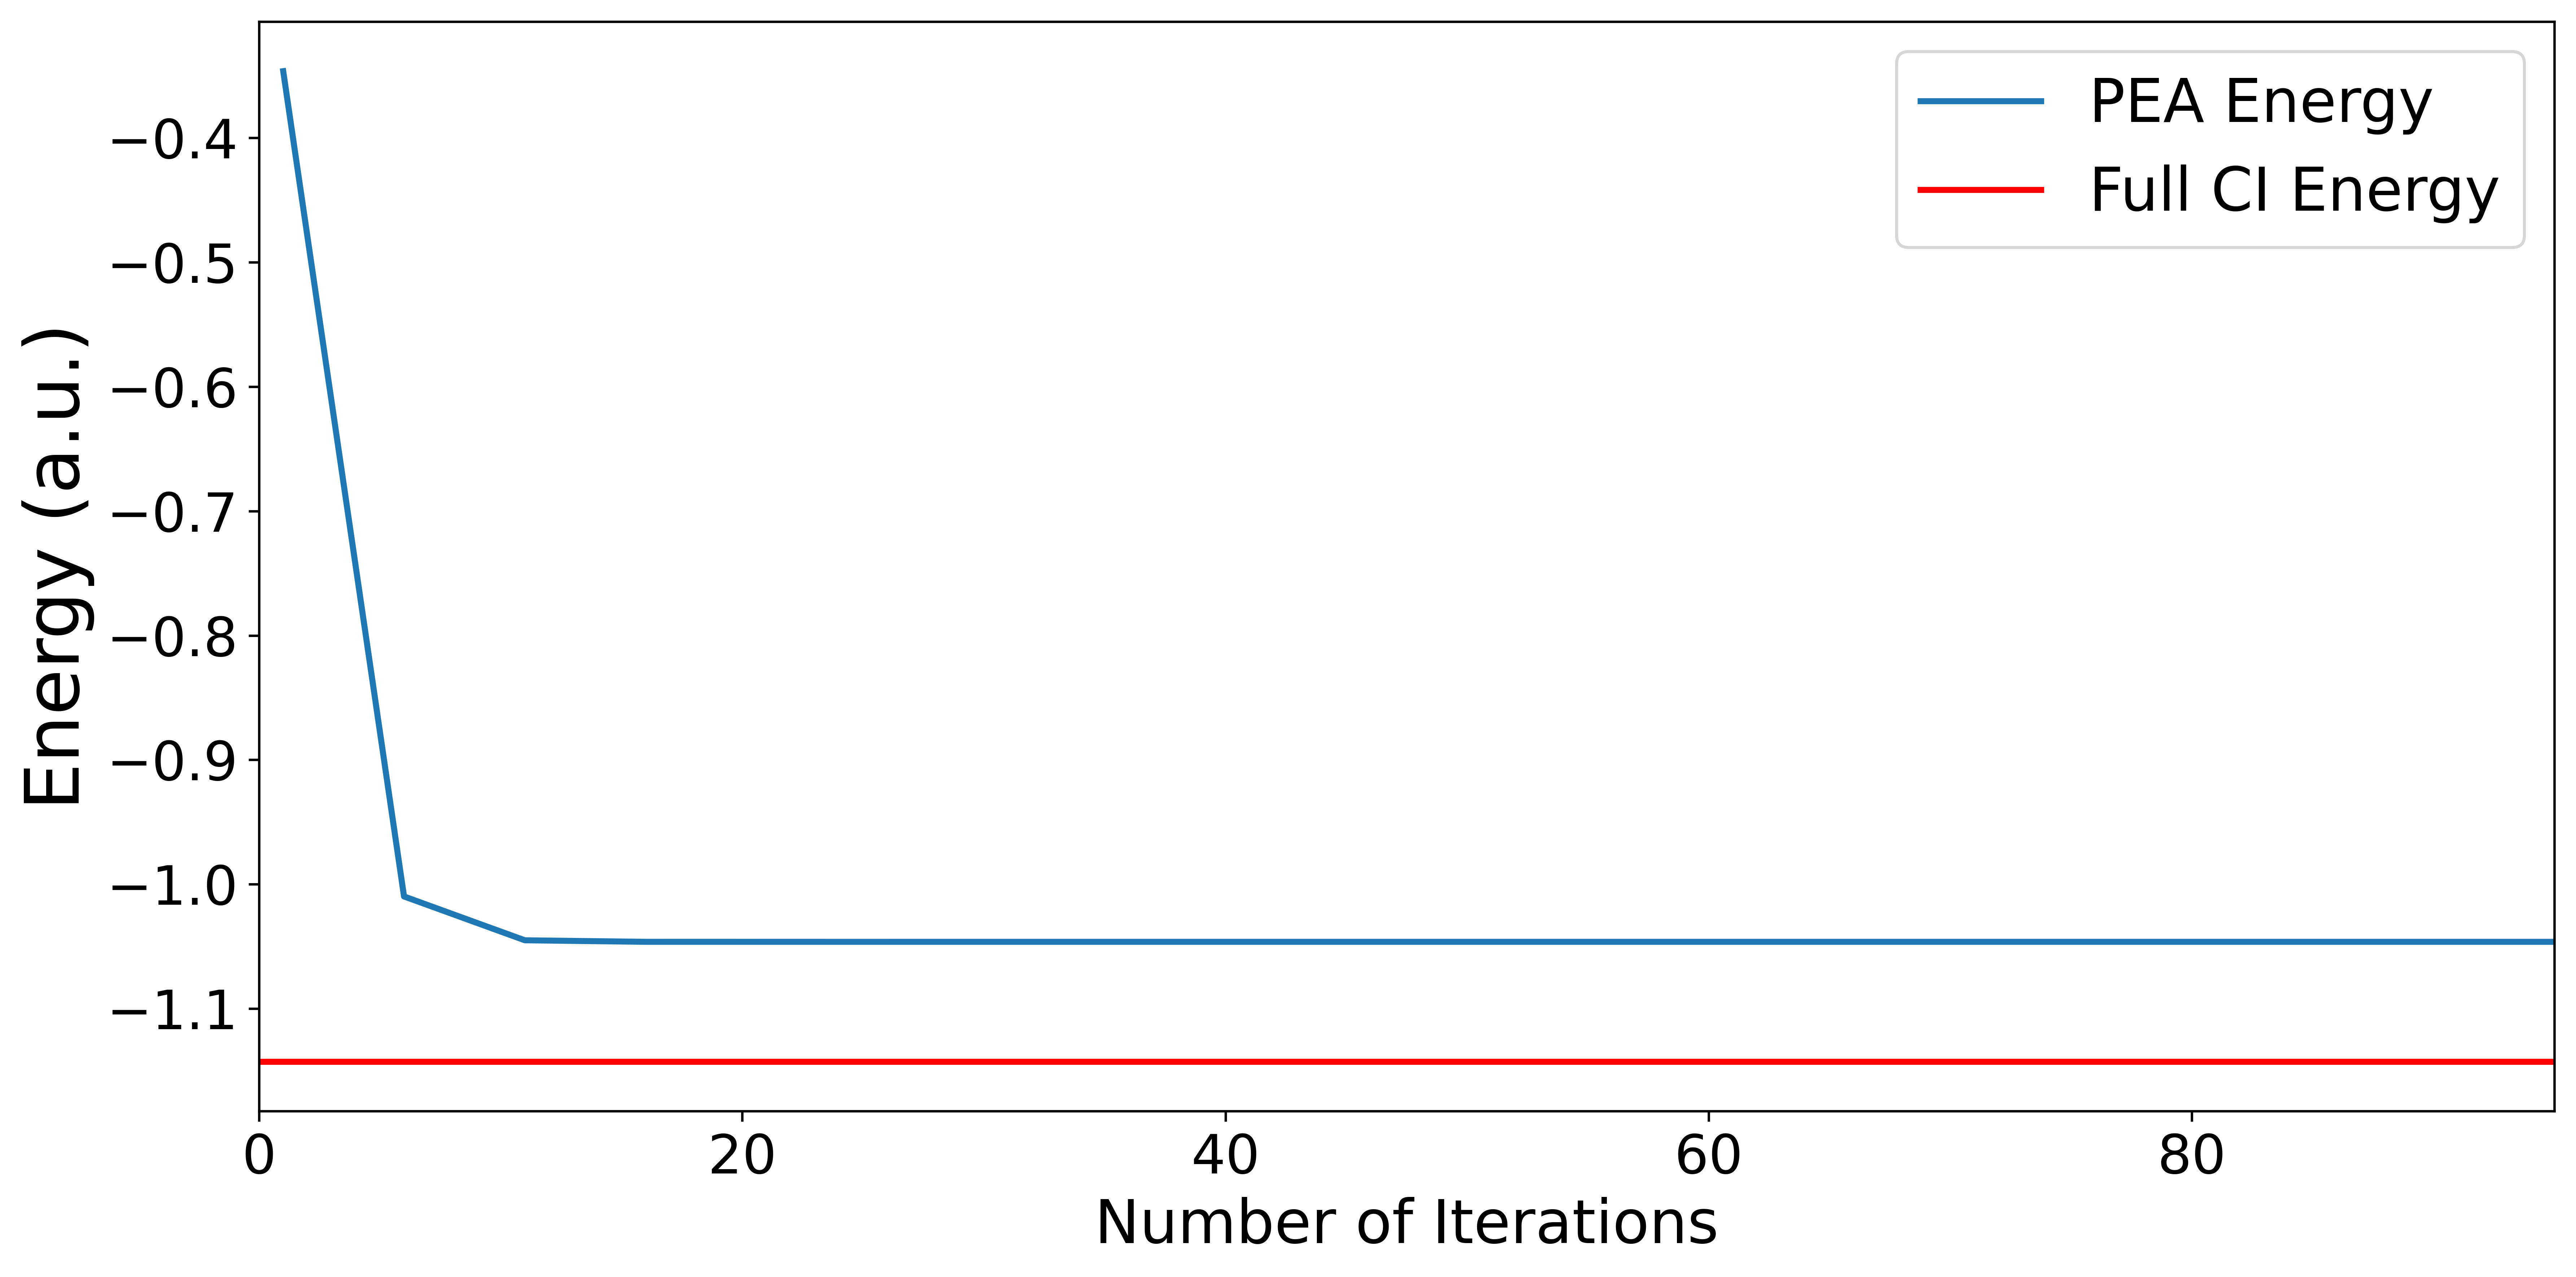

In [4]:
plt.figure(figsize=(12,6),dpi=600)
plt.plot(k_list,E_list, label='PEA Energy',linewidth=2)
plt.xlabel('Number of Iterations',fontsize=20)
plt.ylabel('Energy (a.u.)',fontsize=25)
plt.axhline(-1.1425717116,xmin=0,xmax=95,c="red",linewidth=2,zorder=0,label='Full CI Energy')
plt.xticks(size=18)
plt.yticks(fontsize=18)
plt.xlim(0,95)
plt.tight_layout()
plt.legend(fontsize=20)
plt.savefig('E_vs_k_n100.pdf')
plt.show()

We will then generate a list of $n$, then run PEA experiment at $R= 0.75$ Angstrom and $k = 100$. 

In [ ]:
nstep_list = np.arange(1,101,5)
E_list = []
k = 100
num_shot = 1000
bond_length = 0.75
g_list = [-0.4804,0.3288,-0.4347,0.5716,0.0910,0.0910]
t0 = 0.74

for i in range(len(nstep_list)):
    Energy = procedural(t0,g_list,aer_simulator_backend,nstep_list[i],k,num_shot,bond_length)
    E_list.append(Energy)

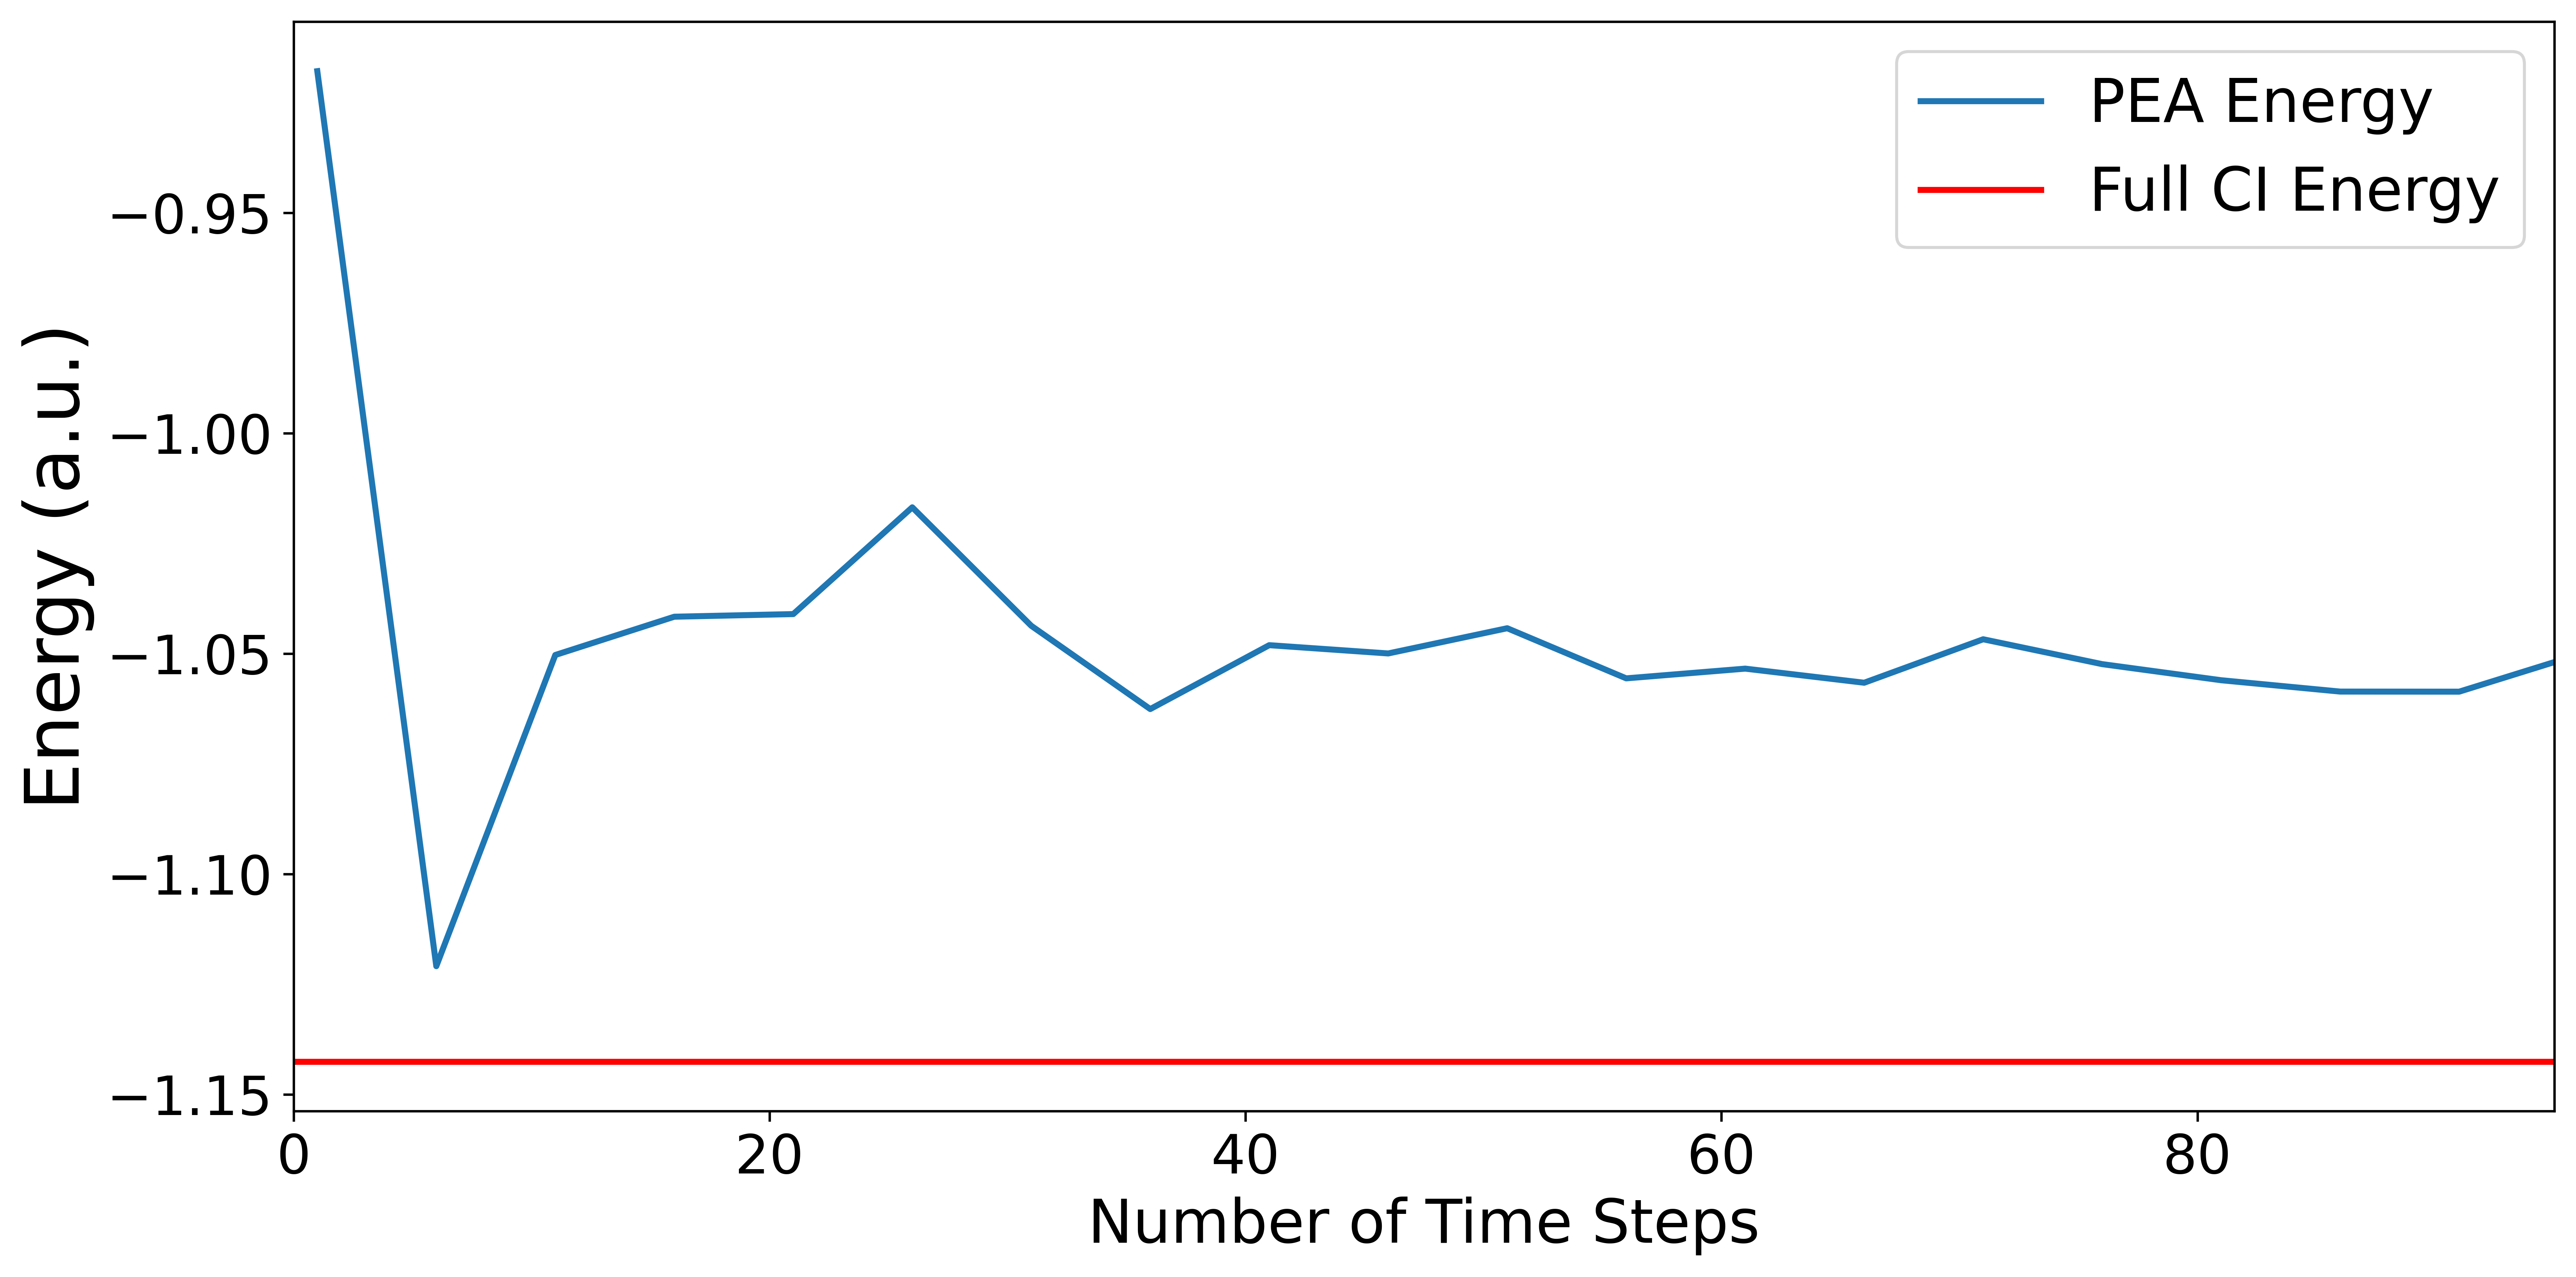

In [6]:
plt.figure(figsize=(12,6),dpi=600)
plt.plot(nstep_list,E_list, label='PEA Energy',linewidth=2)
plt.xlabel('Number of Time Steps',fontsize=20)
plt.ylabel('Energy (a.u.)',fontsize=25)
plt.axhline(-1.1425717116,xmin=0,xmax=95,c="red",linewidth=2,zorder=0,label='Full CI Energy')
plt.xticks(size=18)
plt.yticks(fontsize=18)
plt.xlim(0,95)
plt.tight_layout()
plt.legend(fontsize=20)
plt.savefig('E_vs_nsteps_k100.pdf')
plt.show()

### III.2 Potential Energy Surface about Equilibrium Bond Distance

Below we will determine the potential energy contour of the molecular hydrogen around the equilibrium geometry. We use a 40 timesteps within the Trotter algorithm along with 60 phase estimations to determine this surface. 

In [ ]:
## List containing parameters for each of the bond lengths tested

BD_List=[([-0.2047,0.4754,-0.9145,0.6438,0.0825,0.0825],2.100,0.40),([-0.2677,0.4534,-0.8194,0.6336,0.0835,0.0835],2.310,0.45),
        ([-0.3202,0.4325,-0.7355,0.6233,0.0846,0.0846],2.580,0.50),([-0.3642,0.4125,-0.6612,0.6129,0.0846,0.0846],2.700,0.55),
        ([-0.4012,0.3937,-0.5950,0.6025,0.0870,0.0870],2.250,0.60),([-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883],3.340,0.65),
        ([-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896],0.640,0.70),([-0.4804,0.3435,-0.4347,0.5716,0.0910,0.0190],0.740,0.75),
        ([-0.4989,0.3288,-0.3915,0.5616,0.0925,0.0925],0.790,0.80),([-0.5143,0.3149,-0.3523,0.5518,0.0939,0.0939],3.510,0.85),]

## Procedural that will populate the radii and surface energies, giving
## us the necessary components for the energy.
Energy_surface = []
Radii = []
for i in range(len(BD_List)):
    Radii.append(BD_List[i][2])
    Energy_surface.append(procedural(BD_List[i][1],BD_List[i][0],aer_simulator_backend,40,60,1000,BD_List[i][2]))
    print(i)


In [32]:
## Values pulled from previous calculations
Energy_surface = [-0.8654337762555664, -0.9845551789267986, -0.9927521626755096, -1.145682556817707, -1.14631344749549, -1.1210232762350427, -1.1151882468876906, -1.0393026823787137, -1.0020627255192942, -0.9378637908056751, -0.9169969070763623, -0.8780116082786199]
Radii = [0.40,0.45,0.50,0.55,0.60,0.65,0.75,0.80,0.85,0.90,0.95,1.00]

from scipy.interpolate import make_interp_spline

bond_length = np.arange(0.40,0.80,0.1)
bl_ = np.linspace(0.40,1.00,500)
Energy_Surf_spline = make_interp_spline(Radii,Energy_surface)
Energy_surface_spline = Energy_Surf_spline(bl_)


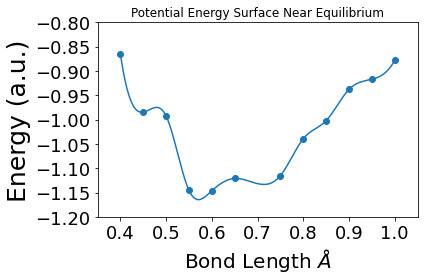

In [33]:
plt.scatter(Radii,Energy_surface)
plt.plot(bl_,Energy_surface_spline)
plt.title("Potential Energy Surface Near Equilibrium")
plt.savefig("PES_Near_Equil_aer_simulator")
plt.xlabel('Bond Length $\AA$',fontsize=20)
plt.ylabel('Energy (a.u.)',fontsize=25)
#plt.axhline(-1.1425717116,xmin=0,xmax=3,c="red",linewidth=2,zorder=0,label='Full CI Energy')
plt.xticks(size=18)
plt.yticks(fontsize=18)
plt.xlim(0.35,1.05)
plt.ylim(-1.2,-0.8)
plt.tight_layout()


As seen in the above plot, there's two main takeaways. First, we get a relative contour that minimizes in the region that we expect, albeit this occurs slightly earlier than is anticipated. Further, this contour predicts an equilibrium bond length much lower than the expected value of 0.72 Angstroms. This can be attributed to several factors, especially in truncating the Trotterized Hamiltonian. It's surprising that the contour is relatively inconsistent between immediate neighbors, but it does well in capturing the overall trend in this region.

### III.3 Running Jobs on IonQ

Although increasing $k$ can improve the accuracy, it would require submitting more jobs on QPU, and they have to be run sequentially. Due to the long wait-time in the queue, the notebook cell will die if we request too many jobs in the for-loop. Therefore, we set $k$ to 3.

Increasing $n$ can also improve the accuracy, however, it requires more gates and a deeper circuit. Considering the CNOT gates in our circuit, we can't set n to be to high. Here we set $n$ to 2.

In order to test our circuit on QPU, we will run energy calculation at different bond length and try to generate a potential energy surface. To assess the accuracy, we also will run PEA experiments on the Aer simulator and calculate energy using Full CI <sup>[8]</sup>. 

##### Full CI Data:
All Full-CI jobs are running using gaussian 16<sup>[9]</sup>. 

In [7]:
bl_longlist = [0.25,
0.5 , 
0.55,
0.60,
0.65,
0.70,
0.75,
0.80,
0.85,
1.  ,
1.25, 
1.5 , 
1.75, 
2.  , 
2.25, 
2.5 , 
2.75]

Energy_FullCI = [1.7927696,
-1.0638723457,
-1.0982599545,
-1.1202320565,
-1.1334002294,
-1.1402607912,                 
-1.1425717116, 
-1.1415975180,
-1.1382675973,                
-1.1202777673,
-1.0828329517,
-1.0497257617,
-1.0254106520,                              
-1.0099449546,                               
-1.0012139787,
-0.9966826008,
-0.9944453352,                                                           
]

##### IonQ QPU Data:
First, we need to store the necessary constants that we're going to use in our simulations

In [8]:
g_values = {}
g_values['0.25'] = [2.1868, 0.5449, -1.2870, +0.6719, +0.0798, +0.0798]
g_values['0.5']  = [-0.3202, 0.4325, -0.7055, +0.6233, +0.0846, +0.0846]
g_values['0.75'] = [-0.4804,0.3288,-0.4347,0.5716,0.0910,0.0910]
g_values['1.0']  = [-0.5463,0.2779,-0.2550,0.5235,0.0986,0.0986]
g_values['1.25'] = [-0.5685,0.2286,-0.1413,0.4812,0.1067,1067]
g_values['1.5']  = [-0.5693,0.1908,-0.0666,0.4451,0.1149,1149]
g_values['1.75'] = [-0.5597,0.1615,-0.0166,0.4148,0.1226,1226]
g_values['2.0']  = [-0.5448,0.1390,0.0171,0.3898,0.1297,1297]
g_values['2.25'] = [-0.5310,0.1221,0.0397,0.3692,0.1359,0.1359]
g_values['2.5']  = [-0.5168,0.1098,0.0549,0.3521,0.1412,0.1412]
g_values['2.75'] = [-0.5039,0.1011,0.0649,0.3379,0.1458,0.1458]

t0_values = {}
t0_values['0.25'] = 1.59
t0_values['0.5']  = 2.58
t0_values['0.75'] = 0.74
t0_values['1.0']  = 4.36
t0_values['1.25'] = 6.360
t0_values['1.5']  = 10.2
t0_values['1.75'] = 0.520
t0_values['2.0']  = 1.95
t0_values['2.25'] = 11.5
t0_values['2.5']  = 0.58
t0_values['2.75'] = 0.45

Select bond lengths and submit jobs to QPU

In [ ]:
k = 3
num_step = 2
num_shot = 1000

bl_k3n2_ionq_qpu = [0.25, 0.5, 0.75, 1.0, 1.25, 2]
Energy_k3n2_ionq_qpu = []

for i in range(len(bl_k3n2_ionq_qpu)):
    bl = bl_k3n2_ionq_qpu[i]
    Energy = procedural(t0_values[str(bl)],g_values[str(bl)],
                        ionq_qpu_backend,num_step,k,num_shot,bl)
    Energy_k3n2_ionq_qpu.append(Energy)

In [9]:
bl_k3n2_ionq_qpu = [0.25, 0.5, 0.75, 1.0, 1.25, 2]

Energy_k3n2_ionq_qpu = [3.137647734625001,
-0.9506082029239804,
-1.407779254896011,                              
-1.171102966119236,
-0.9968290630552491,      
-0.8
]

##### Aer Simulator Data:
We will first use the same $k$ and $n$ as what we use for the QPU

In [ ]:
k = 3
num_step = 2
num_shot = 1000

bl_k3n2_aer_simulator = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5 , 1.75, 2.0 ,  2.5 , 2.75]
Energy_k3n2_aer_simulator = []

for i in range(len(bl_k3n2_aer_simulator)):
    bl = bl_k3n2_aer_simulator[i]
    Energy = procedural(t0_values[str(bl)],g_values[str(bl)],
                        ionq_qpu_backend,num_step,k,num_shot,bl)
    Energy_k3n2_aer_simulator.append(Energy)

In [10]:
bl_k3n2_aer_simulator = [0.25, 0.5, 0.75, 1., 1.25, 1.5 , 1.75, 2.  ,  2.5 , 2.75]

Energy_k3n2_aer_simulator = [2.1497255165150033,
-0.9506082029239804,
-0.8771048201680055,
-0.8108285792396724,
-0.6881033698958748,
-0.7771149226313896,                             
-0.6721130223314284,
-0.6700113945399999,                                                        
-0.657229115632,
-0.6493719233018181                             
]

Since the simulator has less error, we can increase $k$ and $n$ to get more accurate energies

In [ ]:
k = 40
num_step = 60
num_shot = 1000

bl_k40n60_aer_simulator = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5 ,  2.0  , 2.25, 2.5 , 2.75]
Energy_k40n60_aer_simulator = []

for i in range(len(bl_k40n60_aer_simulator)):
    bl = bl_k40n60_aer_simulator[i]
    Energy = procedural(t0_values[str(bl)],g_values[str(bl)],
                        ionq_qpu_backend,num_step,k,num_shot,bl)
    Energy_k40n60_aer_simulator.append(Energy)

In [11]:
bl_k40n60_aer_simulator = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5 ,  2.0  , 2.25, 2.5 , 2.75]

Energy_k40n60_aer_simulator = [2.088371426446803,
-1.0730322166169664,
-1.0448649492051936,
-0.8806392940778366,
-0.7909442327298867,
-0.7963133578103903,                             
-0.8417958667853964,
-0.8257342751795063,
-0.8154574106726464,
-0.806410323438664
]

##### Plotting everything together
We will generate evenly spaced numbers so that we can connect our dots with curves, in order to make our surface look smoother

In [12]:
Energy_FullCI_Spline = make_interp_spline(bl_longlist,Energy_FullCI)
bl_longlist_ = np.linspace(0.25, 2.75, 500)
Energy_FullCI_ = Energy_FullCI_Spline(bl_longlist_)

Energy_k3n2_ionq_qpu_Spline = make_interp_spline(bl_k3n2_ionq_qpu,Energy_k3n2_ionq_qpu)
bl_k3n2_ionq_qpu_ = np.linspace(0.25, 2.75, 500)
Energy_k3n2_ionq_qpu_ = Energy_k3n2_ionq_qpu_Spline(bl_k3n2_ionq_qpu_)

Energy_k3n2_aer_simulator_Spline = make_interp_spline(bl_k3n2_aer_simulator,Energy_k3n2_aer_simulator)
bl_k3n2_aer_simulator_ = np.linspace(0.25, 2.75, 500)
Energy_k3n2_aer_simulator_ = Energy_k3n2_aer_simulator_Spline(bl_k3n2_aer_simulator_)

Energy_k40n60_aer_simulator_Spline = make_interp_spline(bl_k40n60_aer_simulator,Energy_k40n60_aer_simulator)
bl_k40n60_aer_simulator_ = np.linspace(0.25, 2.75, 500)
Energy_k40n60_aer_simulator_ = Energy_k40n60_aer_simulator_Spline(bl_k40n60_aer_simulator_)

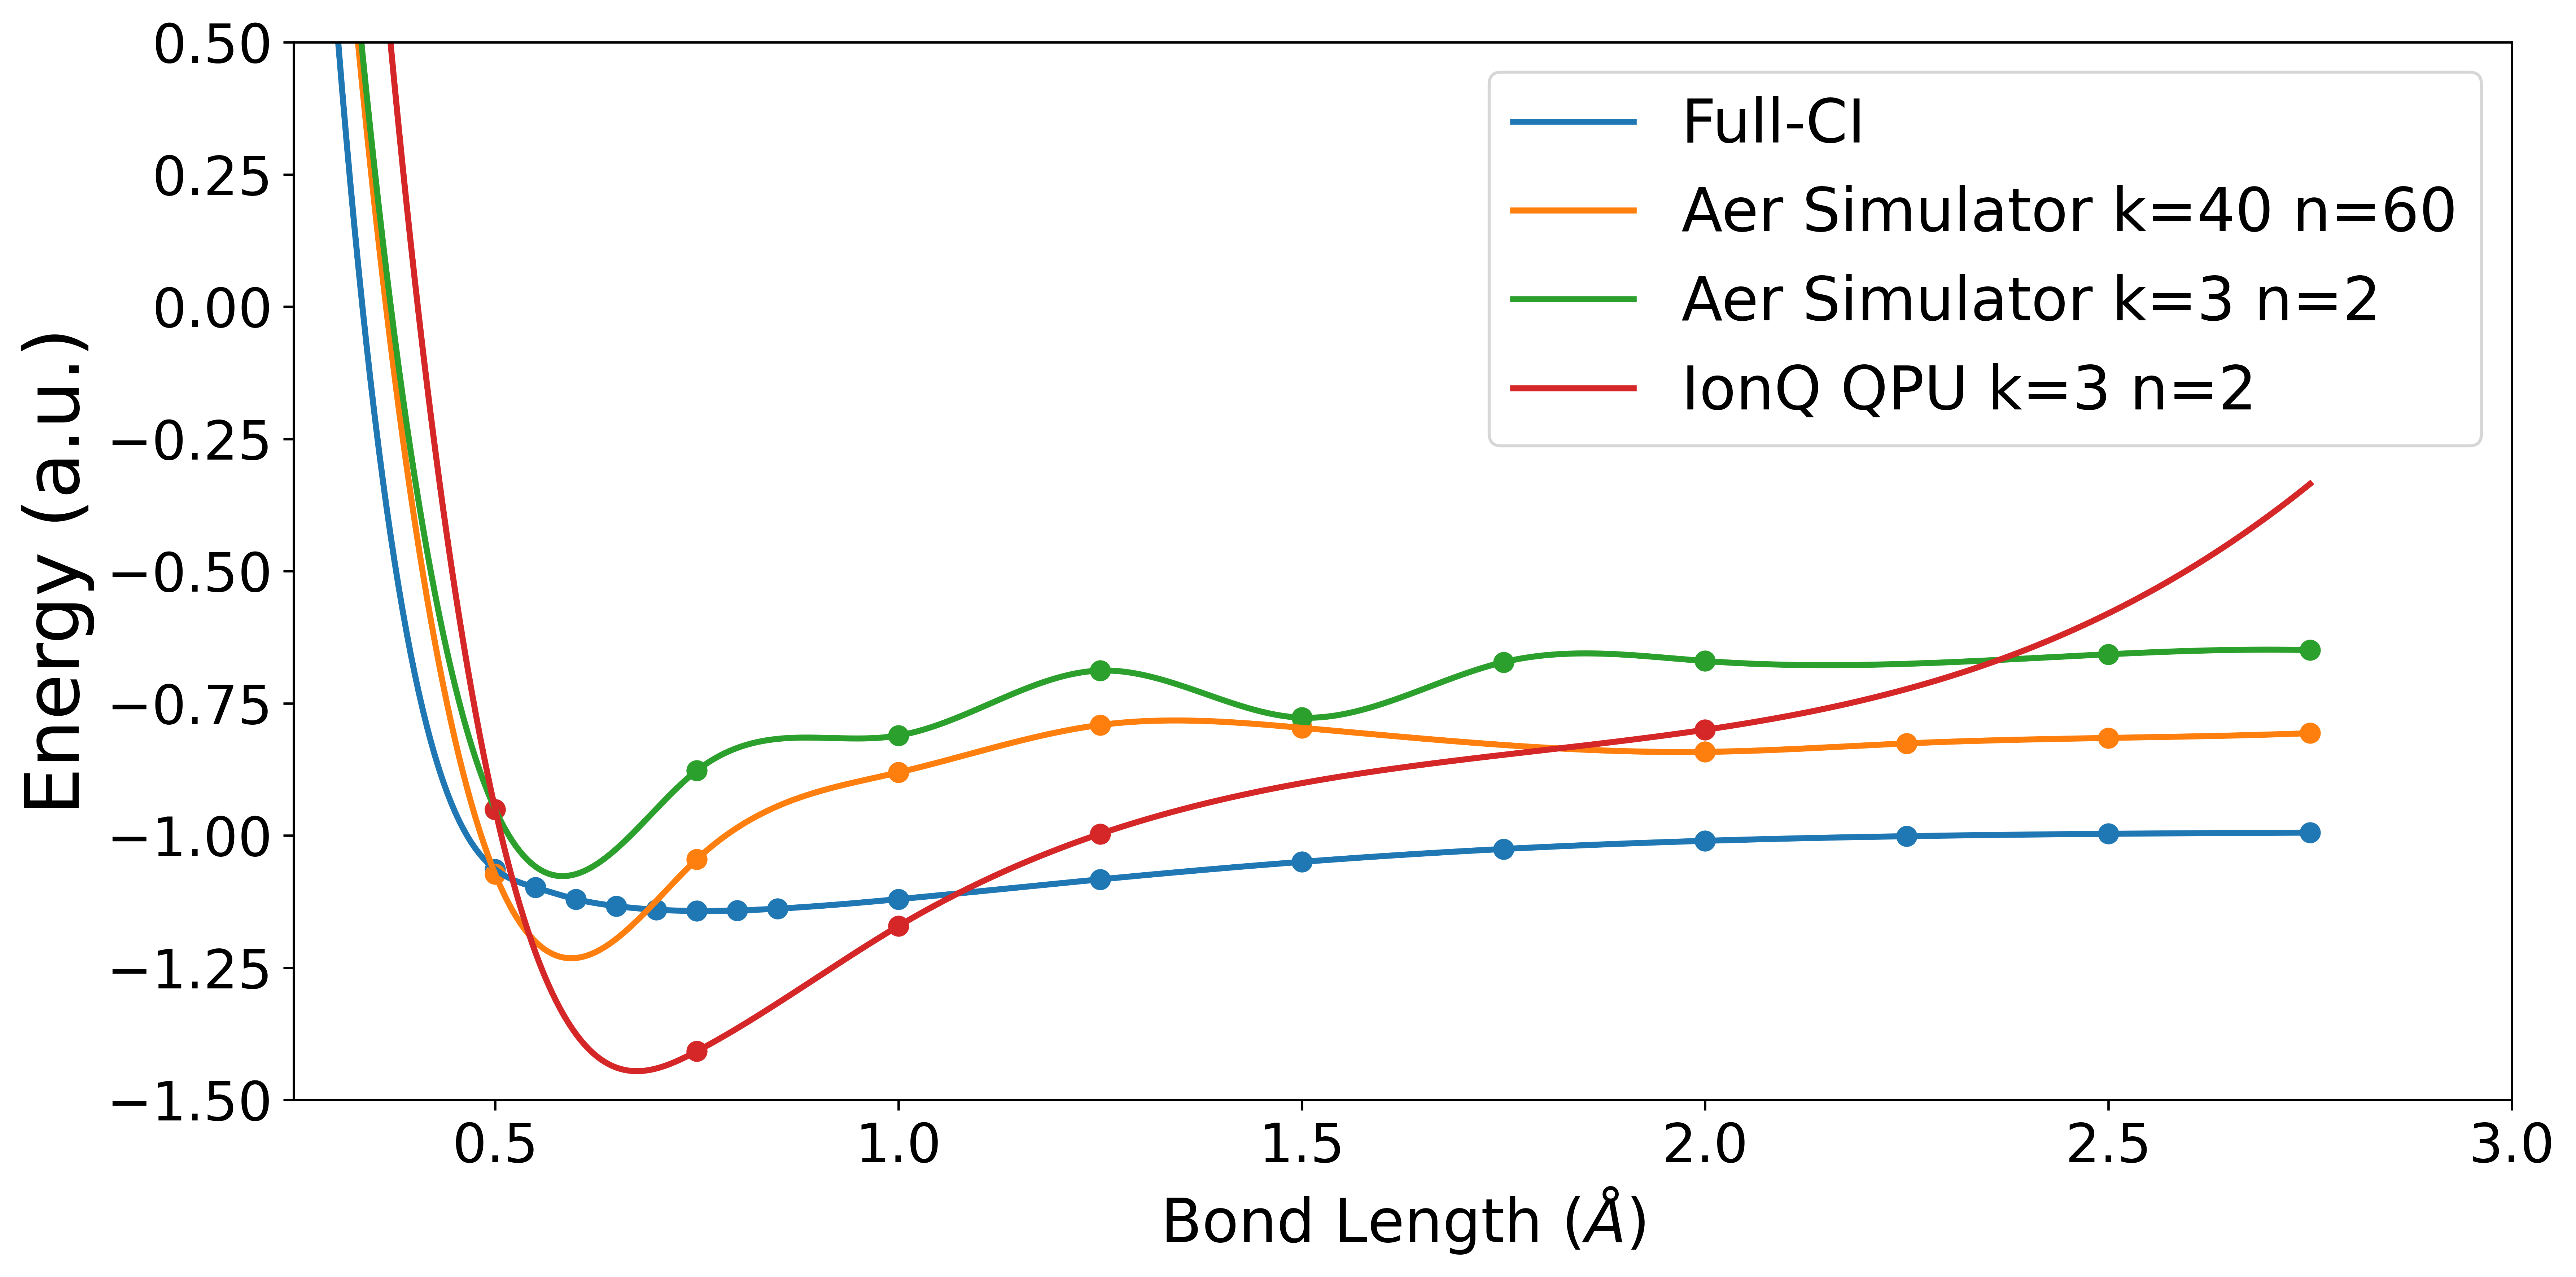

In [13]:
plt.figure(figsize=(12,6),dpi=600)
plt.scatter(bl_longlist,Energy_FullCI)
plt.plot(bl_longlist_,Energy_FullCI_, label='Full-CI',linewidth=2)

plt.scatter(bl_k40n60_aer_simulator,Energy_k40n60_aer_simulator)
plt.plot(bl_k40n60_aer_simulator_,Energy_k40n60_aer_simulator_, label='Aer Simulator k=40 n=60',linewidth=2)

plt.scatter(bl_k3n2_aer_simulator,Energy_k3n2_aer_simulator)
plt.plot(bl_k3n2_aer_simulator_,Energy_k3n2_aer_simulator_, label='Aer Simulator k=3 n=2',linewidth=2)

plt.scatter(bl_k3n2_ionq_qpu,Energy_k3n2_ionq_qpu)
plt.plot(bl_k3n2_ionq_qpu_,Energy_k3n2_ionq_qpu_, label='IonQ QPU k=3 n=2',linewidth=2)

plt.xlabel('Bond Length $(\AA$)',fontsize=20)
plt.ylabel('Energy (a.u.)',fontsize=25)
plt.xticks(size=18)
plt.yticks(fontsize=18)
plt.xlim(0.25,3)
plt.ylim(-1.5,0.5)
plt.tight_layout()
plt.legend(fontsize=20)
plt.savefig('PES.pdf')
plt.show()

As one can see from the graph, increasing $k$ and $n$ on the simulator can allow us to get a more accurate surface. As expected, The QPU has a relatively larger error compared to the the simulator. This proves the viability of running our PEA experiment on the QPU. If more measure are taken for error correction and more resources are used, we can get a better potential energy surface.

## Conclusion

We performed the implementation of Trotterized time-evolution operator and measure the molecular energy using iterative PEA. The trotterized time evolution is controlled on ancilla qubit and the phase-kickback rotation on the qubit determined by previous measurements to fully measure the phase.

As a result, we observed a dependence of PEA results on the number of Trotter steps that we used and the number of phase estimation steps. When we compare the result to the full configuration interaction (full CI) results, both show a trend of decreasing error as $k$ or $n$ grows.

We are also able to obtain a potential energy surface for the hydrogen molecule. When we plot the near-equilibrium energies vs the bond length, the graph shows a minimum near the equilibrium bond angle. 

Finally, when we compare the potential energy surface obtained from the Aer simulator and ionQ QPU with the full CI, we can see the result matchs the trend of the exact energy with a little gap. We do noticed that the greater the number of Trotter steps and the number of phase estimation steps, the better it agrees with the full CI curve.

We observe a substantial deviation from the ideal for both Aer-simulated PEA and QPU-simulated PEA. There are a few possible reasons for the errors. The authors of the original paper were able to tune the physical qubits they used in the superconducting quantum computer for the best results. We refered to their parameters but we were not able to do the same for the ionQ trapped ion quantum computers we used. Another concern is the gate errors from the simulator and the QPU. We would assume that the authors of the paper found a way to error-correct the results that we did not perform due to the time constraints.

## References

<sup>[1]</sup> P.J.J. O'Malley, R. Babbush, I.D. Kivlichan, J. Romero, J.R. McClean, R. Barends, J. Kelly, P. Roushan, A. Tranter, N. Ding <em>et al</em>., <em>Scalable Quantum Simulation of Molecular Energies</em>, Phys. Rev. X **6**, 031007 (2016)

<sup>[2]</sup> N. Hatano and M. Suzuki., <em> Finding exponential product formulas of higher orders</em>, 2005, Lecture Notes in Physics, Berlin Springer Verlag, 679, 37 (arXiv:math-ph/0506007) 

<sup>[3]</sup> I. Dhand and B.C. Sanders, <em>Stability of the Suzuki-Trotter decomposition</em>, J. Phys. A **47**, 265206 (2014)

<sup>[4]</sup> K. Wright, K. Beck, S. Debnath, J. Amini, Y. Nam, N. Grzesiak, J.-S. Chen, N. Pisenti, M. Chmielewski, C. Collins, <em>et al</em>., <em>Benchmarking an 11-qubit quantum computer</em>, Nat. Commun. **10** (1), 1 (2019)

<sup>[5]</sup> N. Klco and M. J. Savage, <em>Digitization of Scalar Fields for Quantum Computing</em>, Phys. Rev. A 99, 052335 (2019)

<sup>[6]</sup> A.Yu.Kitaev, <em>Quantum measurements and the Abelian Stabilizer Problem</em> (arXiv:quant-ph/9511026)

<sup>[7]</sup> M. Dobsicek, G. Johansson, V.S. Shumeiko, G. Wendin, <em>Arbitrary accuracy iterative phase estimation algorithm as a two qubit benchmark</em> Phys. Rev. A **76**, 030306(R) (2007)

<sup>[8]</sup> Olsen, J.; Jorgensen, P.; Koch, H.; Balkova, A.; Bartlett, R. J. <em>Full Configuration–interaction and State of the Art Correlation Calculations on Water in a Valence Double‐zeta Basis with Polarization Functions.</em> J. Chem. Phys. 1996, **104** (20), 8007–8015

<sup>[9]</sup> Frisch, M. J.; Trucks, G. W.; Schlegel, H. B.; Scuseria, G. E. Gaussian 16. **2016**